In [207]:
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.cm as cm
from utils import make_matching_plot_fast,process_resize,frame2tensor,VideoStreamer
import matplotlib.pyplot as plt
import numpy as np
import torch
%matplotlib inline

## 1.keypoints detection(LoFTR)

In [208]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    raise RuntimeError("GPU is required to run this demo.")

def keypoint_detection(img0,img1,device):
    
    conf_threshold = 0.5
    img0_tensor = frame2tensor(img0,device)
    img1_tensor = frame2tensor(img1,device)
    data = {'image0': img0_tensor, 'image1': img1_tensor}
    
    matcher = KF.LoFTR(pretrained='indoor_new').eval().to(device=device)
    
    with torch.inference_mode():
        correspondences = matcher(data)
        
    total_n_matches = len(correspondences['keypoints0'])
    mkpts0 = correspondences['keypoints0'].cpu().numpy()
    mkpts1 = correspondences['keypoints1'].cpu().numpy()
    mconf = correspondences['confidence'].cpu().numpy()
    
    ind = mconf> conf_threshold
    total_n_matches = ind.sum()
    mkpts0 = mkpts0[ind]
    mkpts1 = mkpts1[ind]
    mconf = mconf[ind]
    
    return total_n_matches,mkpts0,mkpts1,mconf

## 2. Compute F_mat here; Test the result in step 5
       (K R t are from the calibration file.)

In [209]:
import torch

scale_x = 640 / 1920
scale_y = 480 / 1080
cam0 = {
    "K": torch.tensor([[1399.965713 * scale_x, 0.0, 943.129998 * scale_x],
                        [0.0, 1394.609791 * scale_y, 554.244042 * scale_y],
                        [0.0, 0.0, 1.0]]),
    "R": torch.tensor([[-0.6456051742, 0.03473953627, 0.7628808057],
                       [0.09040156866, 0.9954173139, 0.03117575436],
                       [-0.7583017311, 0.08909284986, -0.6457870769]]),
    "t": torch.tensor([[20.06419515],
                       [126.2317869],
                       [289.6604271]])
}

cam1 = {
    "K": torch.tensor([[1397.07023 * scale_x, 0.0, 936.040984 * scale_x],
                        [0.0, 1392.579762 * scale_y, 561.303222 * scale_y],
                        [0.0, 0.0, 1.0]]),
    "R": torch.tensor([[-0.2919319768, -0.05002387035, 0.9551300086],
                       [0.4259049826, 0.8873553584, 0.1766505412],
                       [-0.8563764748, 0.4583645714, -0.2377419883]]),
    "t": torch.tensor([[-13.59650874],
                       [95.12428493],
                       [337.6892886]])
}

K0, K1 = cam0["K"], cam1["K"]
R0, R1 = cam0["R"], cam1["R"]
t0, t1 = cam0["t"], cam1["t"]

E_mat = K.geometry.epipolar.essential_from_Rt(R0, t0, R1, t1)
F_mat = K.geometry.epipolar.fundamental_from_essential(E_mat, K0, K1)

print("Fundamental matrix: \n", F_mat)

Fundamental matrix: 
 tensor([[ 1.6912e-04, -1.6047e-05,  1.3260e-01],
        [ 2.0521e-06, -9.1550e-05, -1.2537e-01],
        [-2.3900e-01,  1.6837e-01,  1.5129e+01]])


## 3. Video to frames and Select frames

==> Processing video input: /home/jireh/MT/data/hdVideos/hd_00_00.mp4
==> Processing video input: /home/jireh/MT/data/hdVideos/hd_00_21.mp4


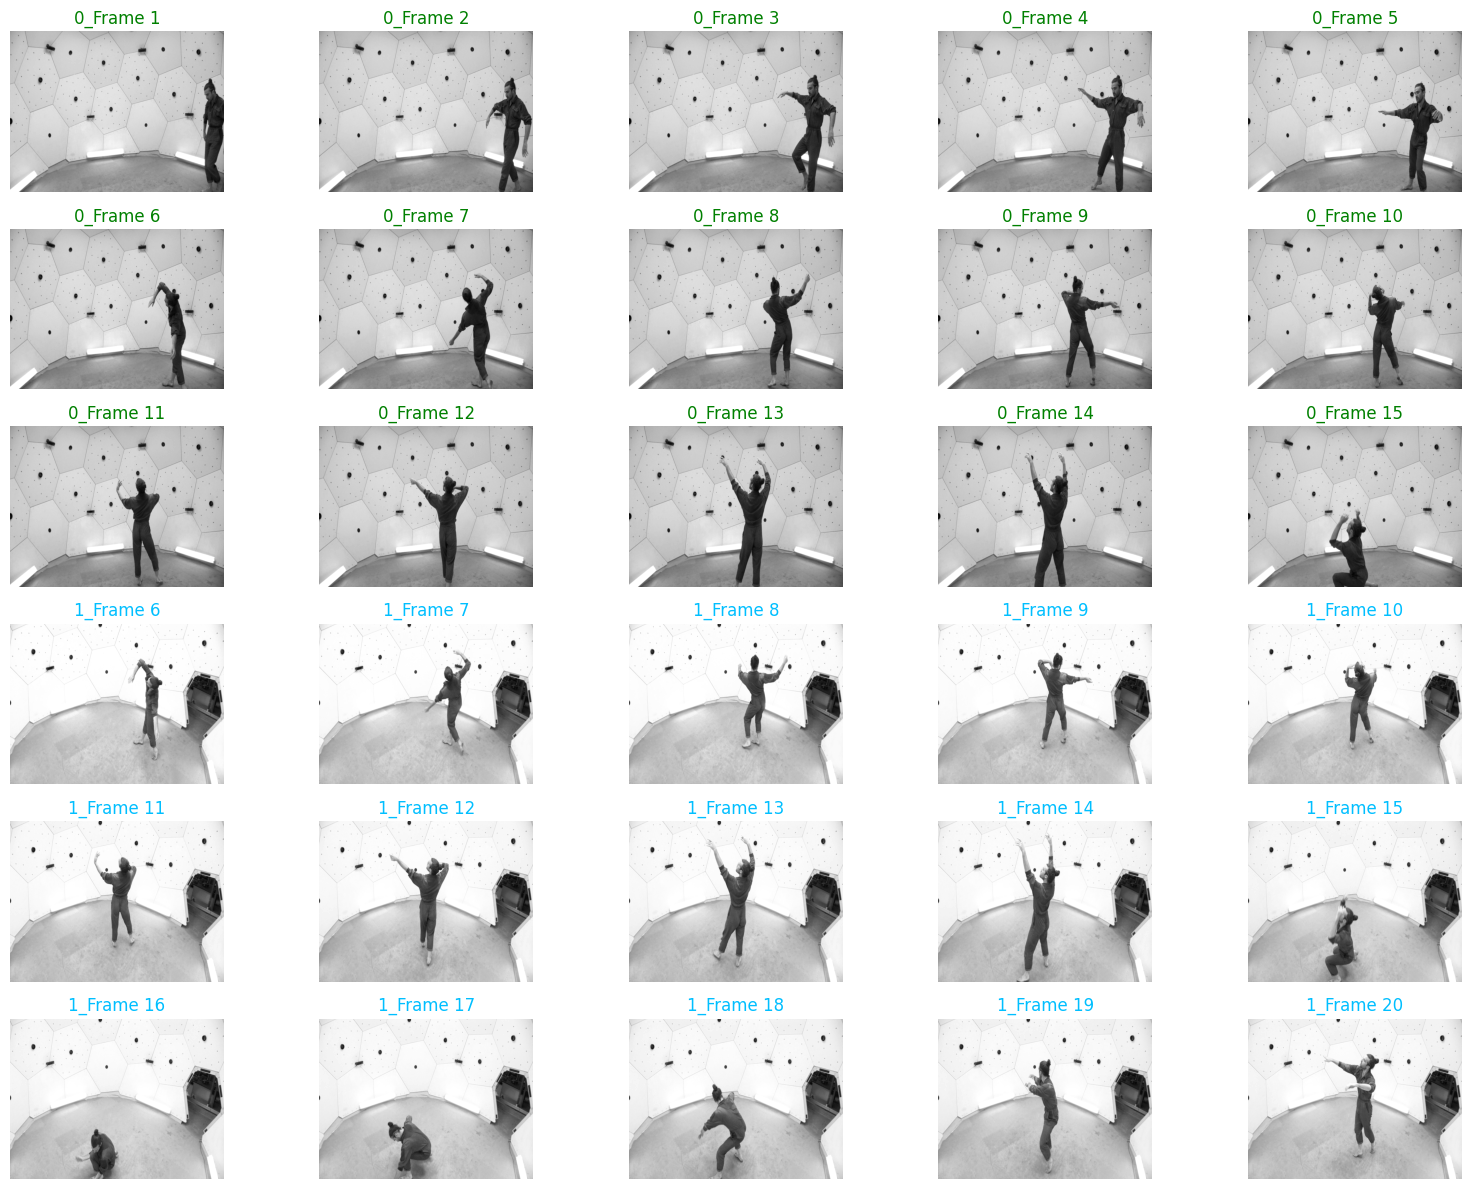

In [210]:
video_input0 = "/home/jireh/MT/data/hdVideos/hd_00_00.mp4"
video_input1 = "/home/jireh/MT/data/hdVideos/hd_00_21.mp4"
skip = 10
max_length = 100000

vs0 = VideoStreamer(video_input0, [640, 480], skip,max_length)
vs1 = VideoStreamer(video_input1, [640, 480], skip,max_length)

fig,axes = plt.subplots(6,5,figsize = (16,12))
for _ in range(10):
    frame0, ret0 = vs0.next_frame()
    frame1, ret1 = vs1.next_frame()
    
frame_set0 = []
frame_set1 = []
for i in range(3):
    for j in range(5):
        frame, ret = vs0.next_frame()
        assert ret, 'Error when reading the first frame (try different --input?)'
        axes[i,j].imshow(frame,cmap='gray')
        axes[i, j].axis('off')  
        axes[i, j].set_title(f"0_Frame {i*5+j+1}",color='green')
        frame_set0.append(frame)

#video1 shift 5 frames
for _ in range(5):
    frame, ret = vs1.next_frame()

for i in range(3):
    for j in range(5):
        frame, ret = vs1.next_frame()
        assert ret, 'Error when reading the first frame (try different --input?)'
        axes[i+3,j].imshow(frame,cmap='gray')
        axes[i+3, j].axis('off')  
        axes[i+3, j].set_title(f"1_Frame {i*5+j+6}",color='deepskyblue')
        frame_set1.append(frame)

plt.tight_layout()
plt.show()

## 4. To verify the LoFTR and visualize the matching results : is all right.

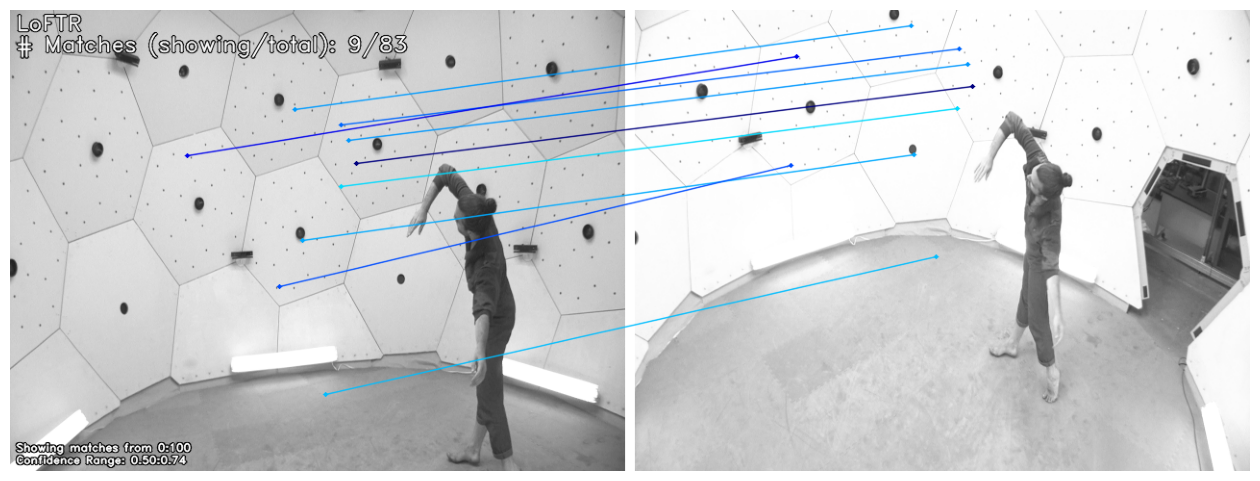

In [211]:
#Create a window to display the demo.
# window_name = 'LoFTR Matches'
# cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
# cv2.resizeWindow(window_name, (640 * 2, 480))
%matplotlib inline

img0 = frame_set0[5]
img1 = frame_set1[0]
total_n_matches,mkpts0,mkpts1,mconf = keypoint_detection(img0,img1,device)

vis_range = [0,100]
#how many points wanna show?
mkpts0 = mkpts0[vis_range[0]:vis_range[1]:10]
mkpts1 = mkpts1[vis_range[0]:vis_range[1]:10]
mconf = mconf[vis_range[0]:vis_range[1]:10]

# Normalize confidence.
if len(mconf) > 0:
    conf_vis_min = 0.
    conf_min = mconf.min()
    conf_max = mconf.max()
    mconf = (mconf - conf_vis_min) / (conf_max - conf_vis_min + 1e-5)

#Low values map to blue, medium values map to green, and high values map to red.
alpha = 0
color = cm.jet(mconf, alpha=alpha) 
text = [
    f'LoFTR',
    '# Matches (showing/total): {}/{}'.format(len(mkpts0), total_n_matches),
]
small_text = [
    f'Showing matches from {vis_range[0]}:{vis_range[1]}',
    f'Confidence Range: {conf_min:.2f}:{conf_max:.2f}',
]
out = make_matching_plot_fast(
    img0, img1, mkpts0, mkpts1, mkpts0, mkpts1, color, text,
    path=None, show_keypoints=False, small_text=small_text)

# cv2.imshow('LoFTR Matches', out)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

plt.figure(figsize=(16,12))
plt.imshow(out)
plt.axis('off')  
plt.show()

## 5. To verify the F_mat:draw epipolar lines on img1 and corresponding points on img0. But it seems not right.

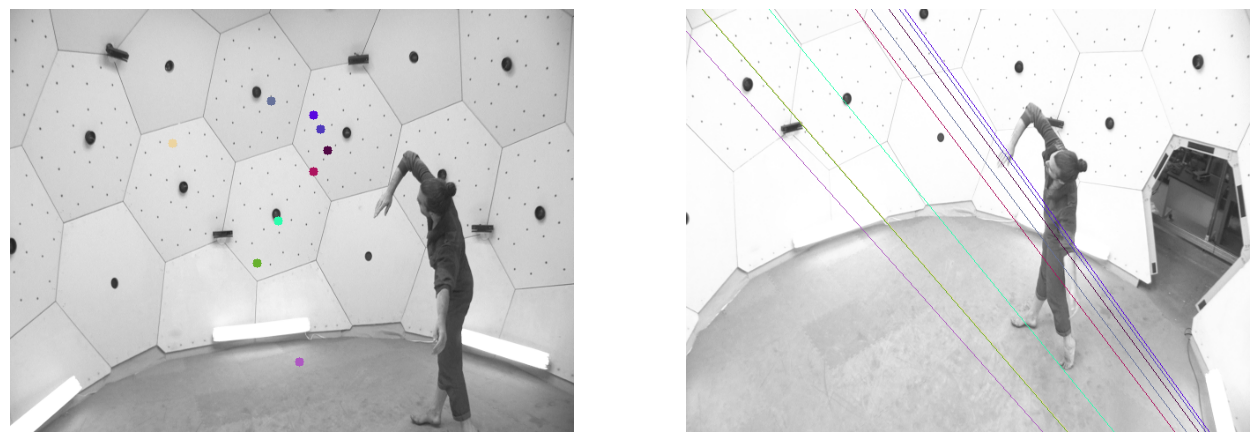

In [212]:
img0 = cv2.cvtColor(img0, cv2.COLOR_GRAY2BGR)
img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)

def draw_epilines(image1,points,image2,Fm):
    """
    For verifing Fm.
    Draw epilines on image2 and corresponding points on image1.
    """
    lines2 = cv2.computeCorrespondEpilines(mkpts0, 1, Fm)
    lines2 = lines2.reshape(-1, 3)

    for r, pt in zip(lines2, points):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [image2.shape[1], -(r[2]+r[0]*image2.shape[1])/r[1]])
        image1 = cv2.circle(image1, tuple(map(int, pt)), 5, color, -1)
        image2 = cv2.line(image2, (x0, y0), (x1, y1), color, 1)
    return image1, image2

def visualize_epipolarline(image1,points,image2,Fm):
    image1_with_points, image2_with_lines = draw_epilines(image1, mkpts0[:30], image2, Fm)
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.imshow(image1_with_points)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(image2_with_lines)
    plt.axis('off')
    plt.show()
    
visualize_epipolarline(img0,mkpts0,img1,np.array(F_mat))

## 6. compute distance(or num of inliers)

In [213]:
#for each frame in video0 and video1
index_f0 = 0
index_f1 = 7   #2,4,6,8
min_distance = 100000
frame1 = frame_set1[index_f1]
for i,frame0 in enumerate(frame_set0):
    total_n_matches,mkpts0,mkpts1,mconf = keypoint_detection(frame0,frame1,device)
    F_mat= torch.Tensor(F_mat.reshape(-1, 3, 3))
    F_mat= F_mat.to(device)
    distances = K.geometry.epipolar.sampson_epipolar_distance(torch.tensor(mkpts0).to(device), torch.tensor(mkpts1).to(device), F_mat, squared=True, eps=1e-08)
    distances = distances.mean()
    if distances < min_distance:
        min_distance = distances
        index_f0 = i+1
    print(f"Matching distances between 0_Frame {i+1} and 1_Frame {index_f1+6}:{distances}; in total:{total_n_matches} matched points")
print(f" Result: 0_Frame {index_f0} corresponds to 1_Frame {index_f1+6}")

Matching distances between 0_Frame 1 and 1_Frame 13:1254.5760498046875; in total:69 matched points
Matching distances between 0_Frame 2 and 1_Frame 13:294.8154296875; in total:119 matched points
Matching distances between 0_Frame 3 and 1_Frame 13:24.22555923461914; in total:199 matched points
Matching distances between 0_Frame 4 and 1_Frame 13:10.782693862915039; in total:295 matched points
Matching distances between 0_Frame 5 and 1_Frame 13:6.561988353729248; in total:305 matched points
Matching distances between 0_Frame 6 and 1_Frame 13:7.485427379608154; in total:322 matched points
Matching distances between 0_Frame 7 and 1_Frame 13:44.666236877441406; in total:227 matched points
Matching distances between 0_Frame 8 and 1_Frame 13:10.699301719665527; in total:261 matched points
Matching distances between 0_Frame 9 and 1_Frame 13:115.4181900024414; in total:93 matched points
Matching distances between 0_Frame 10 and 1_Frame 13:281.5502624511719; in total:67 matched points
Matching di

## Draft below

In [214]:
# Create a window to display the demo.
# window_name = 'LoFTR Matches'
# cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
# cv2.resizeWindow(window_name, (640 * 2, 480))
# %matplotlib inline
# 
# vis_range = [0,50]
# #how many points wanna show?
# # mkpts0 = mkpts0[vis_range[0]:vis_range[1]]
# # mkpts1 = mkpts1[vis_range[0]:vis_range[1]]
# # mconf = mconf[vis_range[0]:vis_range[1]]
# 
# # Normalize confidence.
# if len(mconf) > 0:
#     conf_vis_min = 0.
#     conf_min = mconf.min()
#     conf_max = mconf.max()
#     mconf = (mconf - conf_vis_min) / (conf_max - conf_vis_min + 1e-5)
# 
# #Low values map to blue, medium values map to green, and high values map to red.
# alpha = 0
# color = cm.jet(mconf, alpha=alpha) 
# text = [
#     f'LoFTR',
#     '# Matches (showing/total): {}/{}'.format(len(mkpts0), total_n_matches),
# ]
# small_text = [
#     f'Showing matches from {vis_range[0]}:{vis_range[1]}',
#     f'Confidence Range: {conf_min:.2f}:{conf_max:.2f}',
# ]
# out = make_matching_plot_fast(
#     img0, img1, mkpts0, mkpts1, mkpts0, mkpts1, color, text,
#     path=None, show_keypoints=False, small_text=small_text)
# 
# # cv2.imshow('LoFTR Matches', out)
# # 
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()
# 
# plt.figure(figsize=(16,8))
# plt.imshow(out)
# plt.axis('off')  # 可选：隐藏坐标轴
# plt.show()

## compute distance(or num of inliers)

In [215]:
Fm= torch.Tensor(Fm.reshape(-1, 3, 3))
Fm= Fm.to(device)
distances = K.geometry.epipolar.sampson_epipolar_distance(torch.tensor(mkpts0).to(device), torch.tensor(mkpts1).to(device), Fm, squared=True, eps=1e-08)
score = distances.mean()
print(f"Matching score between img0 and img1:{score}; in total:{total_n_matches} matched points")

NameError: name 'Fm' is not defined

In [ ]:
# def load_image(impath):
#     """ Read image as grayscale and resize to img_size.
#     Inputs
#         impath: Path to input image.
#     Returns
#         grayim: uint8 numpy array sized H x W.
#     """
#     grayim = cv2.imread(impath, 0)
#     if grayim is None:
#         raise Exception('Error reading image %s' % impath)
#     w, h = grayim.shape[1], grayim.shape[0]
#     w_new, h_new = process_resize(w, h, [640, 480])
#     grayim = cv2.resize(
#         grayim, (w_new, h_new), interpolation=cv2.INTER_AREA)
#     return grayim
# 

In [ ]:
# def Fm(img0,img1,device):
#     total_n_matches,mkpts0,mkpts1,mconf = keypoint_detection(img0,img1,device)
#     Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
#     inliers = inliers > 0
#     s = inliers.sum() #num of inliers
#     print("selected points: ", mkpts0.shape)
#     print("Fundamental Matrix: \n", Fm)
#     print("Inliers: ", s)